# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

In [7]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'rice_export_amount', 'inflation', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'w

# Model

In [9]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_all = ['hommali_price','hommali_price_index',
             'agri_prod_index', 'crops_prod_index','paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
             'agri_export_value', 'rice_export_value','rice_export_amount', 
             'inflation', 'pol_rate', 'neer', 'reer','inflation' , 'cpi_rice',
             'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6', 
             'sirikit_water', 'bhumibol_water',
             'water_station_B10','water_station_C13', 'water_station_C2', 'water_station_G8',
             'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
             'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
             'water_station_M6A', 'water_station_M7', 'water_station_N1',
             'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
             'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
             'water_station_Y17', 'water_station_Y1C']

# Adjust X to match the same periods
X = df[xvars_all]

In [10]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 45), (25, 45), (201,), (25,))

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [13]:
label = 'nonglu_price'
df = df[xvars_all + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [14]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 45), (25, 45), (201,), (25,))

In [16]:
# Prediction
y_pred = lr.predict(X_test)

In [17]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 1084325.0754
Linear Regression Model RMSE: 1041.3093
Linear Regression Model R-squared: 0.0140


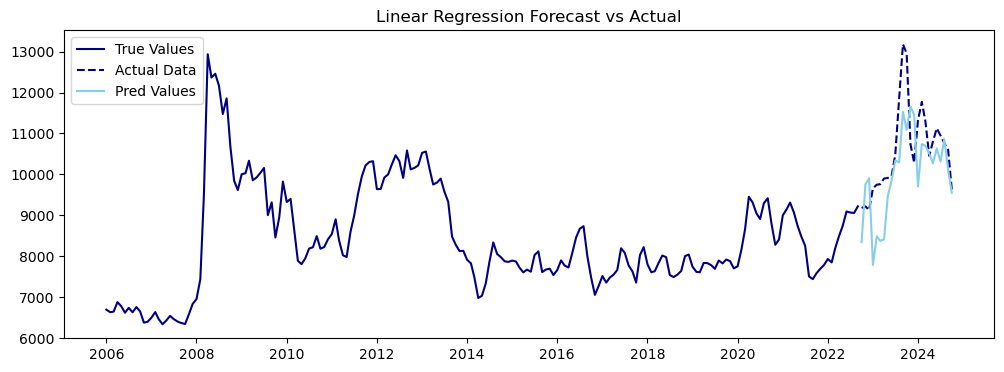

In [18]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/all/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [20]:
#print regression coefficients
lr_coef = pd.DataFrame(zip(X.columns, lr.coef_))
lr_coef

,0,1
0,hommali_price,-3.102838e+08
1,hommali_price_index,2.384273e+10
2,agri_prod_index,2.117206e+01
3,crops_prod_index,-1.887369e+01
4,paddy_prod_index,-2.060576e+00
5,nonglu_prod_index,1.243635e+00
6,hommali_prod_index,1.380319e+00
7,agri_export_value,9.301296e-03
8,rice_export_value,1.038307e+01
9,rice_export_amount,-5.018055e-03


## 2. ARIMA Model

### Model 2 : ARIMA

In [23]:
# # Adding shock event from 2008 rice crisis from January to May 2008
# X_train['shock_event_1'] = [1 if (date >= pd.to_datetime('2008-01-01') and date <= pd.to_datetime('2008-05-01')) 
#                           else 0 for date in  X_train.index]
# X_test['shock_event_1'] = [1 if (date >= pd.to_datetime('2008-01-01') and date <= pd.to_datetime('2008-05-01'))
#                          else 0 for date in  X_test.index]
                           
# # Adding shock event from India lifts export restrictions on rice
# X_train['shock_event_2'] = [1 if (date >= pd.to_datetime('2022-07-01') and date <= pd.to_datetime('2024-09-01')) 
#                           else 0 for date in  X_train.index]
# X_test['shock_event_2'] = [1 if (date >= pd.to_datetime('2022-07-01') and date <= pd.to_datetime('2024-09-01'))
#                          else 0 for date in  X_test.index]

In [24]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [25]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [26]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 927613.9877
ARIMAX(2,1,2) Model RMSE :963.1272
ARIMAX(2,1,2) Model R-squared :0.1565


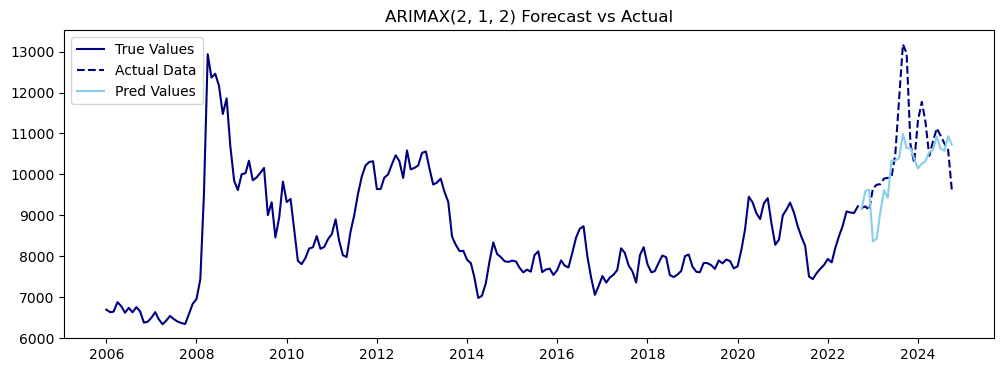

In [27]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/all/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [29]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1431.200
Date:                Thu, 19 Dec 2024   AIC                           2962.400
Time:                        11:21:00   BIC                           3127.316
Sample:                    01-01-2006   HQIC                          3029.139
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
hommali_price           0.1857      0.078      2.372      0.018       0.032       0.339
hommali_price_index     0.0024      0.001      2.411      0.016       0.000       0.004
agri_prod_index       -10.2446     15.022     -0.682      0.495     -39.688      19.199
crops_prod_index        5.6006     11.003      0.509      0.611     -15.965      27.166
paddy_prod_index        1.7552      3.248      0.540      0.589      -4.611       8.121
nonglu_prod_index      -1.4903      2.102     -0.709      0.478      -5.611       2.630
hommali_prod_index     -0.2429      1.162     -0.209      0.834      -2.520       2.034
agri_export_value       0.2973      0.233      1.278      0.201      -0.159       0.753
rice_export_value       2.7612      1.266      2.180      0.029       0.279       5.243
rice_export_amount     -0.0012      0.001     -2.136      0.033      -0.002      -0.000
inflation             -11.5736     50.045     -0.231      0.817    -109.659      86.512
pol_rate              404.3476    252.999      1.598      0.110     -91.521     900.216
neer                    4.3059    102.570      0.042      0.967    -196.727     205.339
reer                   -3.3390    101.736     -0.033      0.974    -202.739     196.061
inflation             -11.5736     50.045     -0.231      0.817    -109.659      86.512
cpi_rice               98.9877     21.042      4.704      0.000      57.747     140.228
fertilizer_1           -0.1124      0.107     -1.048      0.295      -0.323       0.098
fertilizer_2           -0.0385      0.066     -0.581      0.561      -0.168       0.091
fertilizer_3            0.0075      0.104      0.072      0.943      -0.197       0.212
fertilizer_4           -0.0058      0.038     -0.153      0.878      -0.080       0.069
fertilizer_5            0.2168      0.098      2.217      0.027       0.025       0.409
fertilizer_6            0.0123      0.072      0.170      0.865      -0.130       0.154
sirikit_water           0.7352      0.581      1.266      0.205      -0.403       1.873
bhumibol_water         -0.2789      0.182     -1.535      0.125      -0.635       0.077
water_station_B10      -0.0815      1.240     -0.066      0.948      -2.512       2.349
water_station_C13      -0.0580      0.109     -0.533      0.594      -0.271       0.155
water_station_C2        0.0802      0.168      0.478      0.632      -0.248       0.409
water_station_G8       -0.2806      1.562     -0.180      0.857      -3.342       2.781
water_station_K10      -0.2267      0.214     -1.060      0.289      -0.646       0.192
water_station_K11A      0.0735      0.236      0.311      0.755      -0.389       0.536
water_station_Kgt3      0.2765      0.234      1.179      0.238      -0.183       0.736
water_station_Kh103     1.7047      2.341      0.728      0.466      -2.884       6.293
water_station_Kh58A    -0.4710      0.513     -0.918      0.359      -1.477       0.535
water_station_Kh72     -1.5384      3.055     -0.504      0.615      -7.5

### Model 3 : Auto ARIMA

In [31]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        11:21:01   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [32]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 1013237.4336
ARIMAX(2,0,0) Model RMSE :1006.5970
ARIMAX(2,0,0) Model R-squared :0.0787


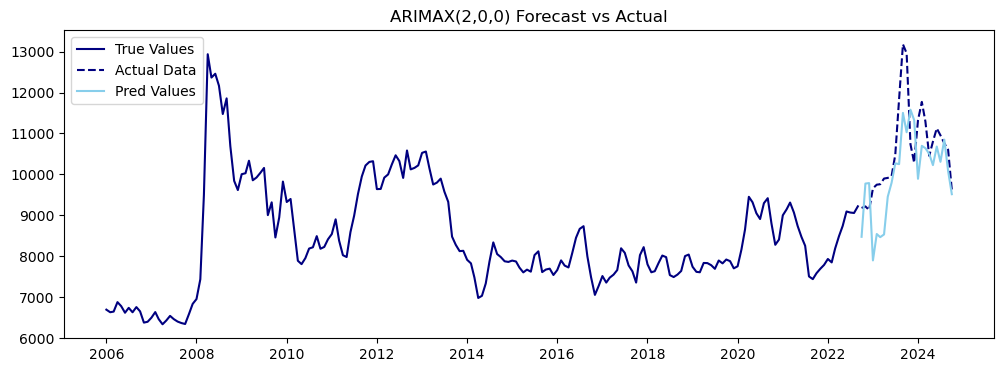

In [34]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/all/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [36]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1485.939
Date:                Thu, 19 Dec 2024   AIC                           3069.877
Time:                        11:21:18   BIC                           3231.739
Sample:                    01-01-2006   HQIC                          3135.373
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9711.7533      2.288   4244.217      0.000    9707.268    9716.238
hommali_price           0.0185      0.057      0.323      0.747      -0.094       0.131
hommali_price_index     0.0002      0.001      0.333      0.739      -0.001       0.002
agri_prod_index        21.3512     21.549      0.991      0.322     -20.884      63.586
crops_prod_index      -18.9986     15.478     -1.227      0.220     -49.336      11.338
paddy_prod_index       -2.0877      4.501     -0.464      0.643     -10.909       6.734
nonglu_prod_index       1.2609      2.837      0.444      0.657      -4.300       6.822
hommali_prod_index      1.3900      1.667      0.834      0.404      -1.878       4.658
agri_export_value      -0.0012      0.294     -0.004      0.997      -0.578       0.575
rice_export_value      10.4345      1.387      7.524      0.000       7.716      13.153
rice_export_amount     -0.0049      0.001     -7.555      0.000      -0.006      -0.004
inflation              -8.8106     10.629     -0.829      0.407     -29.642      12.021
pol_rate               34.2388    165.698      0.207      0.836    -290.523     359.001
neer                   49.0039     36.187      1.354      0.176     -21.921     119.928
reer                  -81.5077     45.504     -1.791      0.073    -170.693       7.678
inflation              -8.8106     10.629     -0.829      0.407     -29.642      12.021
cpi_rice              123.9738     19.144      6.476      0.000      86.453     161.495
fertilizer_1            0.1702      0.091      1.867      0.062      -0.009       0.349
fertilizer_2           -0.1175      0.051     -2.298      0.022      -0.218      -0.017
fertilizer_3            0.2108      0.125      1.688      0.091      -0.034       0.456
fertilizer_4            0.1194      0.055      2.157      0.031       0.011       0.228
fertilizer_5            0.0134      0.115      0.116      0.907      -0.212       0.239
fertilizer_6           -0.1344      0.084     -1.604      0.109      -0.299       0.030
sirikit_water           0.4822      0.801      0.602      0.547      -1.087       2.052
bhumibol_water         -0.1827      0.295     -0.619      0.536      -0.762       0.396
water_station_B10      -4.0202      1.572     -2.557      0.011      -7.102      -0.939
water_station_C13      -0.0033      0.159     -0.021      0.983      -0.314       0.307
water_station_C2       -0.0415      0.230     -0.181      0.857      -0.491       0.408
water_station_G8        2.0349      2.778      0.733      0.464      -3.410       7.480
water_station_K10      -0.1466      0.324     -0.453      0.651      -0.781       0.488
water_station_K11A      0.0935      0.315      0.297      0.767      -0.524       0.711
water_station_Kgt3      0.6337      0.296      2.138      0.033       0.053       1.215
water_station_Kh103    -0.3213      3.619     -0.089      0.929      -7.415       6.772
water_station_Kh58A    -0.4467      0.965     -0.463      0.644      -2.3

## 4. GARCH Model

### Model 4 : GARCH

In [39]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [40]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)

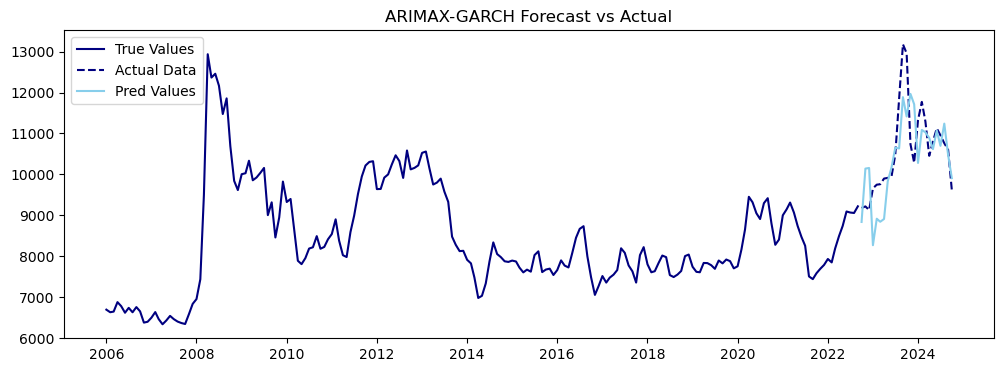

In [41]:
# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/all/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [43]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 15408.330672168033
alpha (ARCH term): 0.12180020560619675
beta (GARCH term): 0.7789102137096091


# Compare the score of models

In [45]:
score_df = pd.DataFrame(data = {'feature' : ['all'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/all.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,all,Linear,1.084325e+06,1041.309308,0.014025
1,all,"ARIMAX(2,0,0)",1.013237e+06,1006.596957,0.078665
2,all,GARCH,7.144746e+05,845.265987,0.350329
